In [1]:
!python --version

Python 3.10.5


In [2]:
#Preprocessing code borrowed from Fabrizio Ravelli: https://www.kaggle.com/code/fabrizioravelli/alzheimer-s-disease-classification-98-acc

import os
import cv2
import random
from tqdm import tqdm
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras.backend as K

from keras import models
from keras import layers
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import Model



CLASSES = ("MILD_DEMENTED", "NON_DEMENTED", "VERYMILD_DEMENTED")
DATASET_DIR = "data/"
TEST_DIR = DATASET_DIR + "test/"
TRAINING_DIR = DATASET_DIR + "train/"

IMG_SIZE = 100

def create_data(directory):
    data = []
    for CLASSE in CLASSES:
        path = os.path.join(directory, CLASSE)
        class_num = CLASSES.index(CLASSE)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data.append((img_array, class_num))
            
    return data

train_data = create_data(TRAINING_DIR)
test_data = create_data(TEST_DIR)

random.shuffle(train_data)
random.shuffle(test_data)

def prepare_data(data):
    inp = []
    out = []
    
    for img, label in data:
        inp.append(img)
        y = np.zeros(len(CLASSES))
        y[label] = 1
        out.append(y)
    inp = np.array(inp).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    
    return inp, out

X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

X_train = X_train / 255
y_train = np.array(y_train)

X_test = X_test / 255
y_test = np.array(y_test)

for classe in CLASSES:
    class_num = CLASSES.index(classe)
    print(classe, class_num)


100%|█████████████████| 224/224 [00:00<00:00, 794.97it/s]


MILD_DEMENTED 0
NON_DEMENTED 1
VERYMILD_DEMENTED 2


Text(0.5, 0, 'Mild Demented')

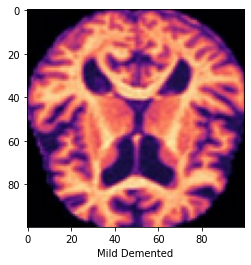

In [3]:
plt.imshow(X_train[6:7][0,:,:,:])
plt.xlabel("Mild Demented")

Text(0.5, 0, 'Very Mild Demented')

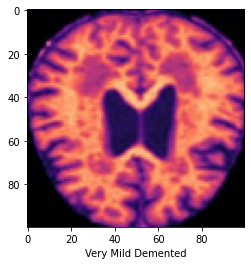

In [4]:
plt.imshow(X_train[37:38][0,:,:,:])
plt.xlabel("Very Mild Demented")

Text(0.5, 0, 'Non Demented')

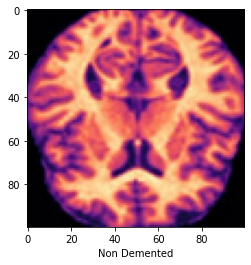

In [5]:
plt.imshow(X_train[65:66][0,:,:,:])
plt.xlabel("Non Demented")

In [6]:
model = models.Sequential([
    layers.Conv2D(32*32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(16*16, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(8*8, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(CLASSES), activation='softmax')], name='modelv1')

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

model.summary()

Model: "modelv1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 1024)      28672     
                                                                 
 average_pooling2d (AverageP  (None, 49, 49, 1024)     0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 49, 49, 1024)     4096      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 256)       2359552   
                                                                 
 average_pooling2d_1 (Averag  (None, 23, 23, 256)      0         
 ePooling2D)                                                     
                                                           

2022-08-15 14:22:05.064887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 14:22:05.094737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 14:22:05.096816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-15 14:22:05.098951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1)

Epoch 1/100


2022-08-15 14:22:07.923962: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


161/161 [==============================] - 31s 166ms/step - loss: 1.1469 - acc: 0.5682 - prec: 0.5854 - rec: 0.5262 - auc: 0.7704 - val_loss: 0.8689 - val_acc: 0.5000 - val_prec: 0.8795 - val_rec: 0.1281 - val_auc: 0.7851
Epoch 2/100
161/161 [==============================] - 24s 149ms/step - loss: 0.7268 - acc: 0.6078 - prec: 0.6403 - rec: 0.5243 - auc: 0.8281 - val_loss: 0.7403 - val_acc: 0.4684 - val_prec: 0.4639 - val_rec: 0.4053 - val_auc: 0.7826
Epoch 3/100
161/161 [==============================] - 24s 149ms/step - loss: 0.6769 - acc: 0.6277 - prec: 0.6500 - rec: 0.5561 - auc: 0.8437 - val_loss: 0.6750 - val_acc: 0.6614 - val_prec: 0.7533 - val_rec: 0.4018 - val_auc: 0.8570
Epoch 4/100
161/161 [==============================] - 24s 149ms/step - loss: 0.6523 - acc: 0.6337 - prec: 0.6668 - rec: 0.5652 - auc: 0.8541 - val_loss: 0.6066 - val_acc: 0.6544 - val_prec: 0.6802 - val_rec: 0.6193 - val_auc: 0.8772
Epoch 5/100
161/161 [==============================] - 24s 150ms/step - loss

In [8]:
test_scores = model.evaluate(X_test, y_test)

print("Testing Loss: %.2f%%"%(test_scores[0] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
print("Testing Precision: %.2f%%"%(test_scores[2] * 100))
print("Testing Recall: %.2f%%"%(test_scores[3] * 100))
print("Testing AUC: %.2f%%"%(test_scores[4] * 100))


20/20 [==============================] - 1s 74ms/step - loss: 0.1533 - acc: 0.9779 - prec: 0.9779 - rec: 0.9779 - auc: 0.9930
Testing Loss: 15.33%
Testing Accuracy: 97.79%
Testing Precision: 97.79%
Testing Recall: 97.79%
Testing AUC: 99.30%


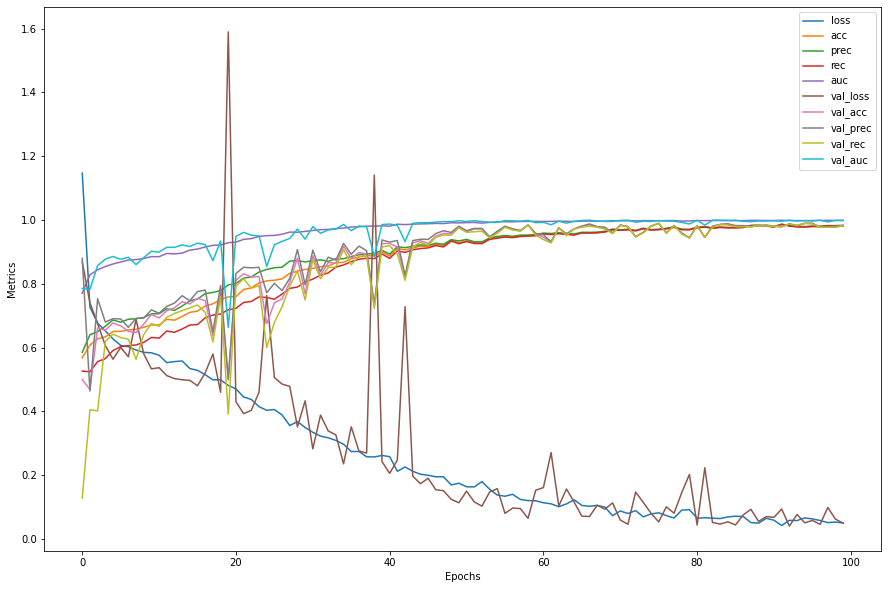

In [9]:
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()

In [10]:
loss_history = history.history['val_loss']

In [11]:
min_loss = 100
min_epoch = 0

for i in range(1,51):
    if loss_history[i] < min_loss:
        min_loss = loss_history[i]
        min_epoch = i


In [12]:
min_epoch

49

In [13]:
model = models.Sequential([
    layers.Conv2D(512, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', name='last_conv_layer'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(CLASSES), activation='softmax')], name='modelv1')

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

history = model.fit(
    X_train, y_train,
    epochs=min_epoch,
    batch_size=32,
    validation_split=0.01)

Epoch 1/49
177/177 [==============================] - 18s 90ms/step - loss: 0.7908 - acc: 0.6044 - prec: 0.6231 - rec: 0.5422 - auc: 0.8112 - val_loss: 1.1306 - val_acc: 0.4035 - val_prec: 0.3636 - val_rec: 0.2105 - val_auc: 0.5977
Epoch 2/49
177/177 [==============================] - 14s 79ms/step - loss: 0.6593 - acc: 0.6493 - prec: 0.6623 - rec: 0.6160 - auc: 0.8565 - val_loss: 1.0841 - val_acc: 0.4035 - val_prec: 0.4500 - val_rec: 0.3158 - val_auc: 0.6440
Epoch 3/49
177/177 [==============================] - 14s 79ms/step - loss: 0.6207 - acc: 0.6691 - prec: 0.6835 - rec: 0.6363 - auc: 0.8705 - val_loss: 0.6029 - val_acc: 0.5614 - val_prec: 0.5741 - val_rec: 0.5439 - val_auc: 0.8530
Epoch 4/49
177/177 [==============================] - 14s 79ms/step - loss: 0.6080 - acc: 0.6686 - prec: 0.6882 - rec: 0.6394 - auc: 0.8754 - val_loss: 0.6524 - val_acc: 0.6491 - val_prec: 0.6667 - val_rec: 0.6316 - val_auc: 0.8739
Epoch 5/49
177/177 [==============================] - 14s 79ms/step - lo

In [14]:
test_scores = model.evaluate(X_test, y_test)

print("Testing Loss: %.2f%%"%(test_scores[0] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
print("Testing Precision: %.2f%%"%(test_scores[2] * 100))
print("Testing Recall: %.2f%%"%(test_scores[3] * 100))
print("Testing AUC: %.2f%%"%(test_scores[4] * 100))

20/20 [==============================] - 0s 20ms/step - loss: 0.1815 - acc: 0.9510 - prec: 0.9510 - rec: 0.9510 - auc: 0.9901
Testing Loss: 18.15%
Testing Accuracy: 95.10%
Testing Precision: 95.10%
Testing Recall: 95.10%
Testing AUC: 99.01%


In [15]:
model = models.Sequential([
    layers.Conv2D(512, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', name='last_conv_layer'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(CLASSES), activation='softmax')], name='modelv1')

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc', Precision(name='prec'), Recall(name='rec'), AUC(name='auc')])

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.01)

Epoch 1/200
177/177 [==============================] - 15s 80ms/step - loss: 0.8021 - acc: 0.5917 - prec: 0.6130 - rec: 0.5424 - auc: 0.8056 - val_loss: 0.7222 - val_acc: 0.6140 - val_prec: 0.6200 - val_rec: 0.5439 - val_auc: 0.8047
Epoch 2/200
177/177 [==============================] - 14s 78ms/step - loss: 0.6494 - acc: 0.6546 - prec: 0.6684 - rec: 0.6225 - auc: 0.8597 - val_loss: 0.8453 - val_acc: 0.5965 - val_prec: 0.6038 - val_rec: 0.5614 - val_auc: 0.8385
Epoch 3/200
177/177 [==============================] - 14s 78ms/step - loss: 0.6156 - acc: 0.6681 - prec: 0.6830 - rec: 0.6443 - auc: 0.8714 - val_loss: 0.5307 - val_acc: 0.5965 - val_prec: 0.6471 - val_rec: 0.5789 - val_auc: 0.8724
Epoch 4/200
177/177 [==============================] - 14s 78ms/step - loss: 0.5987 - acc: 0.6787 - prec: 0.6935 - rec: 0.6496 - auc: 0.8794 - val_loss: 0.5469 - val_acc: 0.7193 - val_prec: 0.7222 - val_rec: 0.6842 - val_auc: 0.8983
Epoch 5/200
177/177 [==============================] - 14s 78ms/step

In [16]:
test_scores = model.evaluate(X_test, y_test)

print("Testing Loss: %.2f%%"%(test_scores[0] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
print("Testing Precision: %.2f%%"%(test_scores[2] * 100))
print("Testing Recall: %.2f%%"%(test_scores[3] * 100))
print("Testing AUC: %.2f%%"%(test_scores[4] * 100))

20/20 [==============================] - 0s 20ms/step - loss: 0.0292 - acc: 0.9874 - prec: 0.9874 - rec: 0.9874 - auc: 0.9998
Testing Loss: 2.92%
Testing Accuracy: 98.74%
Testing Precision: 98.74%
Testing Recall: 98.74%
Testing AUC: 99.98%


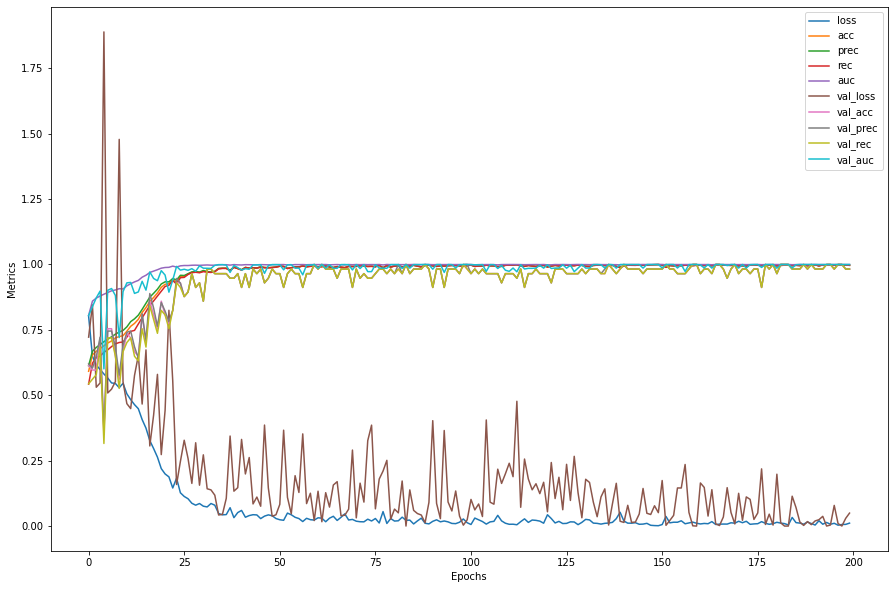

In [17]:
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()

In [19]:
np.save('modelv2_200Epochs.npy',history.history)

In [ ]:
history=np.load('my_history.npy',allow_pickle='TRUE').item()